## 0. 课程大纲

### 0.1 BGR, XYZ, HLS, HSV
```python
cv.cvtColor(img, cv.COLOR_XXX2XXX)
```

### 0.2 图像直方图
```python
cv.calcHist([img], [c1], None, [256], [0,256])
```

### 0.3 实战：铅笔颜色提取
```python
cv.inRange(img, lower, upper)
```

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.show()

## 11. 颜色空间

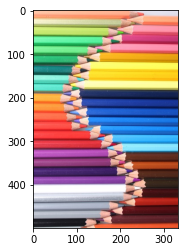

In [3]:
bgr = cv.imread('pic/pencils500x333.jpg')
show(bgr)

### 11.1 BGR2XYZ

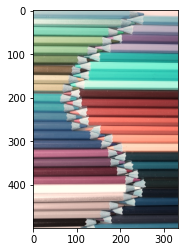

In [4]:
xyz = cv.cvtColor(bgr, cv.COLOR_BGR2XYZ)
show(xyz)

### 11.2 BGR2HLS

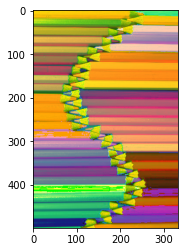

In [6]:
hls = cv.cvtColor(bgr, cv.COLOR_BGR2HLS)
show(hls)

### 11.3 BGR2HSV

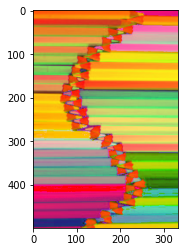

In [7]:
hsv = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)
show(hsv)

### 11.4 颜色直方图

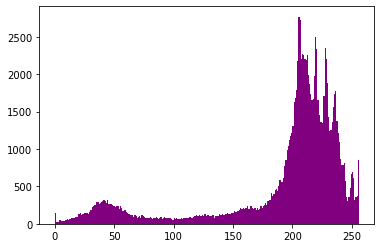

In [5]:
img = cv.imread('pic/computer200x200.jpg')

plt.hist(img.ravel(), bins=256, range=[0, 256], color='purple')
plt.show()

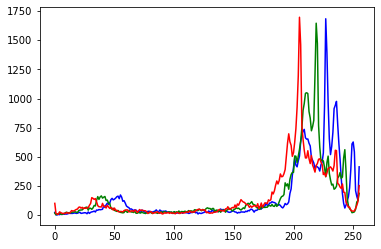

In [11]:
hist_b = cv.calcHist([img], [0], None, [256], [0,256])
hist_g = cv.calcHist([img], [1], None, [256], [0,256])
hist_r = cv.calcHist([img], [2], None, [256], [0,256])

plt.plot(hist_b, 'b') #range(len(hist)), 
plt.plot(hist_g, 'g') #range(len(hist)), 
plt.plot(hist_r, 'r') #range(len(hist)), 

plt.show()

In [8]:
hist_r.shape

(256, 1)

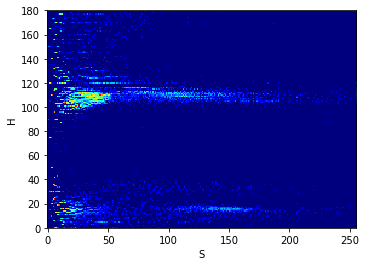

In [6]:
img = cv.imread("pic/computer200x200.jpg")
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
hist = cv.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
# hist = hist / hist.sum()

hist = np.log(hist + 1)

plt.imshow(hist, interpolation='nearest', cmap='jet')
plt.ylim([0, 180])
plt.xlabel('S')
plt.ylabel('H')
plt.show()

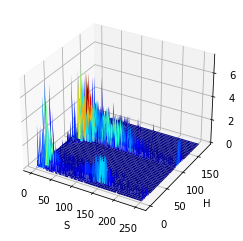

In [7]:
xx = np.arange(0, hist.shape[1])
yy = np.arange(0, hist.shape[0])

xx, yy = np.meshgrid(xx, yy)
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(xx, yy, hist, cmap='jet')
ax.set_xlabel('S')
ax.set_ylabel('H')
plt.show()

### 11.5 实践：颜色提取

In [12]:
# cv.inRange()

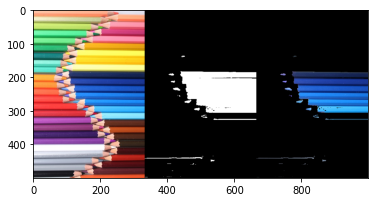

In [44]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def show(img):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.show()
    
    
bgr = cv.imread('pic/pencils500x333.jpg')
hsv = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)

# 蓝色
mask = cv.inRange(hsv, np.array([100, 43, 46]), np.array([124, 255, 255]))

bgr_blue = ((mask == 255) * bgr.transpose((2,0,1))).transpose((1,2,0))
mask3 = cv.merge([mask, mask, mask])
# bgr_blue = np.bitwise_and(mask3, bgr)

show(np.hstack([bgr, mask3, bgr_blue]))

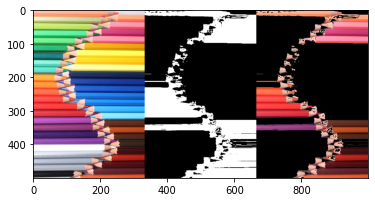

In [43]:
# 红色
mask1 = cv.inRange(hsv, np.array([0, 43, 46]), np.array([10, 255, 255]))
mask2 = cv.inRange(hsv, np.array([156, 43, 46]), np.array([180, 255, 255]))
mask = np.bitwise_or(mask1, mask2)

bgr_red = ((mask == 255) * bgr.transpose((2,0,1))).transpose((1,2,0))

mask3 = cv.merge([mask, mask, mask])
# bgr_blue = np.bitwise_and(mask3, bgr)

show(np.hstack([bgr, mask3, bgr_red]))

In [45]:
cv.imwrite('pic/pencils_colorspace.jpg', np.hstack([bgr, mask30, bgr_blue, mask3, bgr_red]))

True

## 实战：颜色提取2

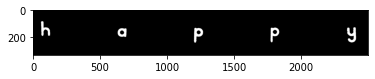

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

bgr = cv.imread('pic/word_happy.jpg')
hsv = cv.cvtColor(bgr, cv.COLOR_BGR2HLS)

d = 20
colors = np.array([
    [2, 137, 194],
    [1, 217, 236],
    [16, 2, 173],
    [223, 90, 125],
    [48, 80, 135],
])
masks = [cv.inRange(bgr, c-d, c+d) for c in colors]

K1 = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
K2 = cv.getStructuringElement(cv.MORPH_RECT, (5,5))

masks = [cv.morphologyEx(m, cv.MORPH_OPEN, K1) for m in masks]
masks = [cv.dilate(m, K2) for m in masks]

plt.imshow(np.hstack(masks), cmap='gray')
plt.show()
# show(np.hstack([bgr, mask3, bgr_blue]))

In [4]:
contours = []
for m in masks:
    cnts, hie = cv.findContours(m, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    
    cnts.sort(key=lambda x:x[:,0,0].max(), reverse=True)
    contours.append(cnts[0])
    print(cv.contourArea(cnts[0]))

3047.0
3576.0
4370.0
4089.0
3953.5


In [5]:
M = np.array(masks).sum(axis=0).astype(np.uint8)
M.shape

(333, 500)

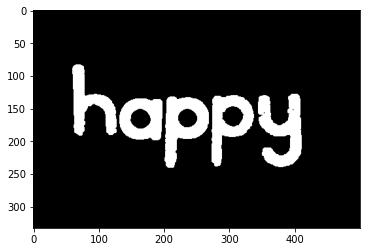

In [8]:
show(M)

In [9]:
cv.imwrite('pic/word_happy_bin.png', M)

True

In [13]:
cnts, hiers = cv.findContours(M, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

areaTh = 2000
words = []

for c, h in zip(cnts, hiers[0]):
    if cv.contourArea(c) > areaTh and h[3] == -1:
        x, y, w, h = cv.boundingRect(c)
        word = M[y:y+h, x:x+w]
        words.append(word)

for i, w in enumerate(words):
    cv.imwrite(f'test/x{i}.png', w)